<a href="https://www.kaggle.com/code/ibrahimnibrahim/walmart-stock-mse-0-01-for-test?scriptVersionId=244218021" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walmart-stock-data-2025/wmt_data.csv


In [2]:
#helper functions:

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache().prefetch(1)
    return dataset

def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(15, 10))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)


    plt.title(title)
    plt.grid(True)
    plt.show()

def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset, verbose=0)
    
    return forecast

In [3]:
data_dir='/kaggle/input/walmart-stock-data-2025/wmt_data.csv'
df=pd.read_csv(data_dir)
df.head()

,date,open,high,low,close,adj_close,volume
0,2000-01-03 00:00:00-05:00,22.791668,23.000000,21.833332,22.270832,14.307388,25109700
1,2000-01-04 00:00:00-05:00,21.833332,21.937500,21.395832,21.437500,13.772032,20235300
2,2000-01-05 00:00:00-05:00,21.291668,21.458332,20.729168,21.000000,13.490974,21056100
3,2000-01-06 00:00:00-05:00,21.000000,21.520832,20.895832,21.229168,13.638196,19633500
4,2000-01-07 00:00:00-05:00,21.500000,22.979168,21.500000,22.833332,14.668746,23930700


In [4]:
from sklearn.model_selection  import train_test_split
from sklearn.preprocessing import MinMaxScaler

dataset = df["close"]
dataset = pd.DataFrame(dataset)


scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

train_set, test_set = train_test_split(scaled_data, test_size=0.2, shuffle=False)

In [5]:
time_step=np.arange(0,len(train_set))
# train_set is a numpy array, access it using numerical index 
close=train_set[:,0] # Access all rows and the first (and only) column
valid_x=np.arange(len(train_set),len(train_set)+len(test_set))
# test_set is also a numpy array
valid_y=test_set[:,0] # Access all rows and the first (and only) column


all_close=np.concatenate((close,valid_y))
all_time=np.concatenate((time_step,valid_x))

(test_set.shape,train_set.shape)

((1269, 1), (5076, 1))

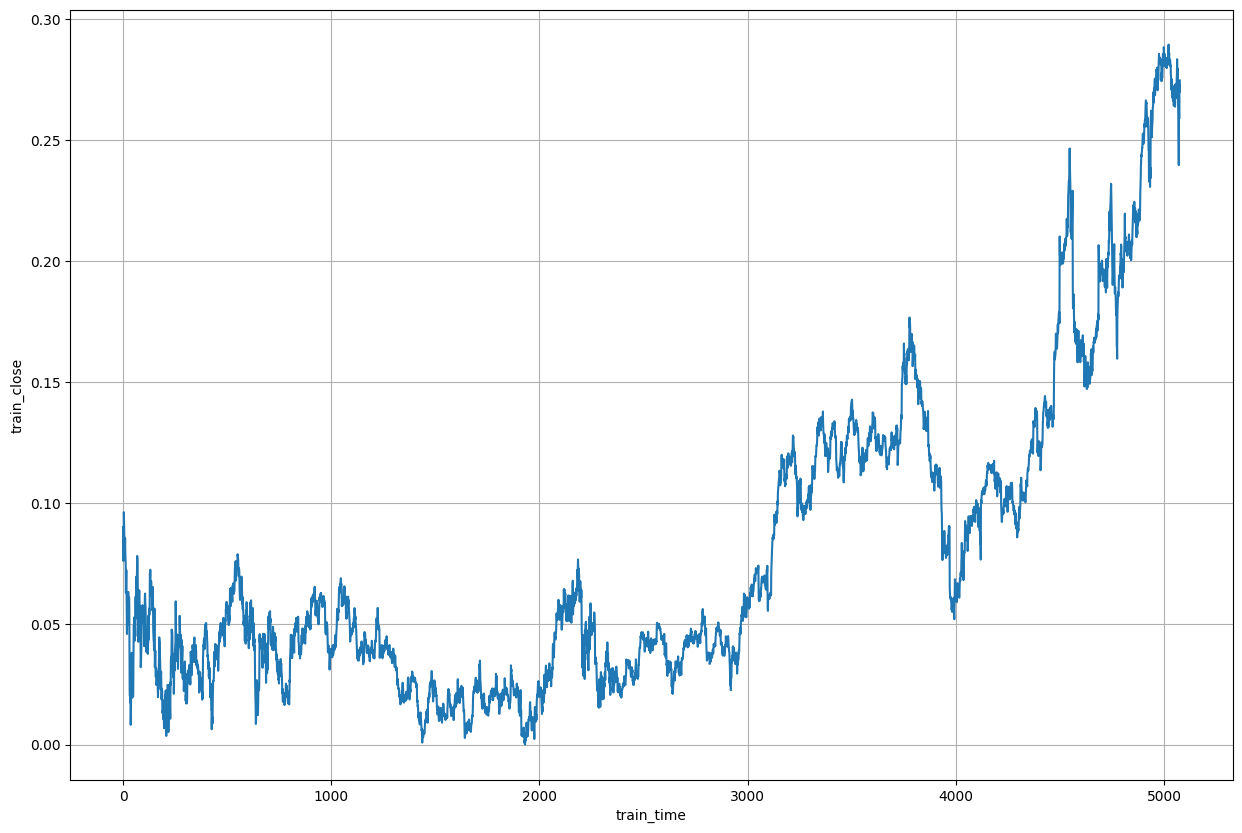

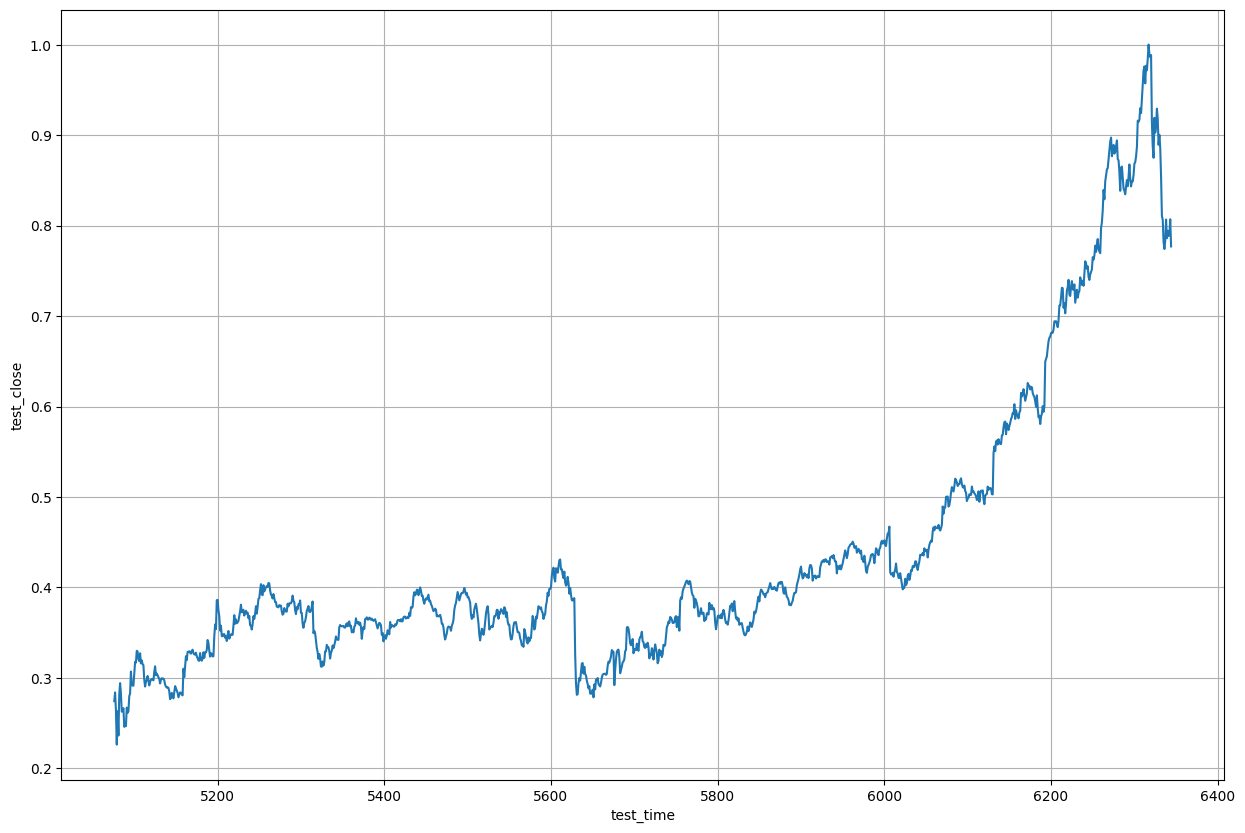

In [6]:
import matplotlib.pyplot as plt

plot_series(time_step,close, xlabel='train_time', ylabel='train_close')
plot_series(valid_x,valid_y, xlabel='test_time', ylabel='test_close')

In [7]:
import tensorflow as tf

# Parameters
window_size = 15
batch_size = 64
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(close, window_size, batch_size, shuffle_buffer_size)
test_set = windowed_dataset(valid_y, window_size, batch_size, shuffle_buffer_size)

2025-06-07 11:58:08.519410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749297488.764287      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749297488.838318      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-07 11:58:23.239530: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,1)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100)
])

 # Print the model summary 
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 15, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 15, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30)                  │           1,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             310 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,191 (203.87 KB)

 Trainable params: 52,191 (203.87 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
tf.keras.backend.clear_session()

model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mse"])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='mse', 
    patience=30,  
    restore_best_weights=True,
    mode='min'
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='mse', 
    factor=0.1, 
    patience=10, 
    mode='min',
    min_lr=1e-10
)

history = model.fit(train_set,epochs=50,callbacks=[early_stopping,reduce_lr])

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.0260 - mse: 0.0522 - learning_rate: 0.0010
Epoch 2/50
 7/80 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.2267e-05 - mse: 8.4534e-05

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.9521e-05 - mse: 5.9042e-05 - learning_rate: 0.0010
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.6534e-05 - mse: 1.3307e-04 - learning_rate: 0.0010
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 4.6664e-05 - mse: 9.3328e-05 - learning_rate: 0.0010
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 2.7241e-05 - mse: 5.4481e-05 - learning_rate: 0.0010
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.0964e-05 - mse: 6.1929e-05 - learning_rate: 0.0010
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 7.6123e-05 - mse: 1.5225e-04 - learning_rate: 0.0010
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.0738e-04 - mse: 2.1476e-04 - learning_rate: 0.0010
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.9328e-05 - mse: 5.8657e-05 - learning_rate: 0.0010
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 4.6118e-05 - mse: 9.2237e-05 - learning_rate: 0.0010
Ep

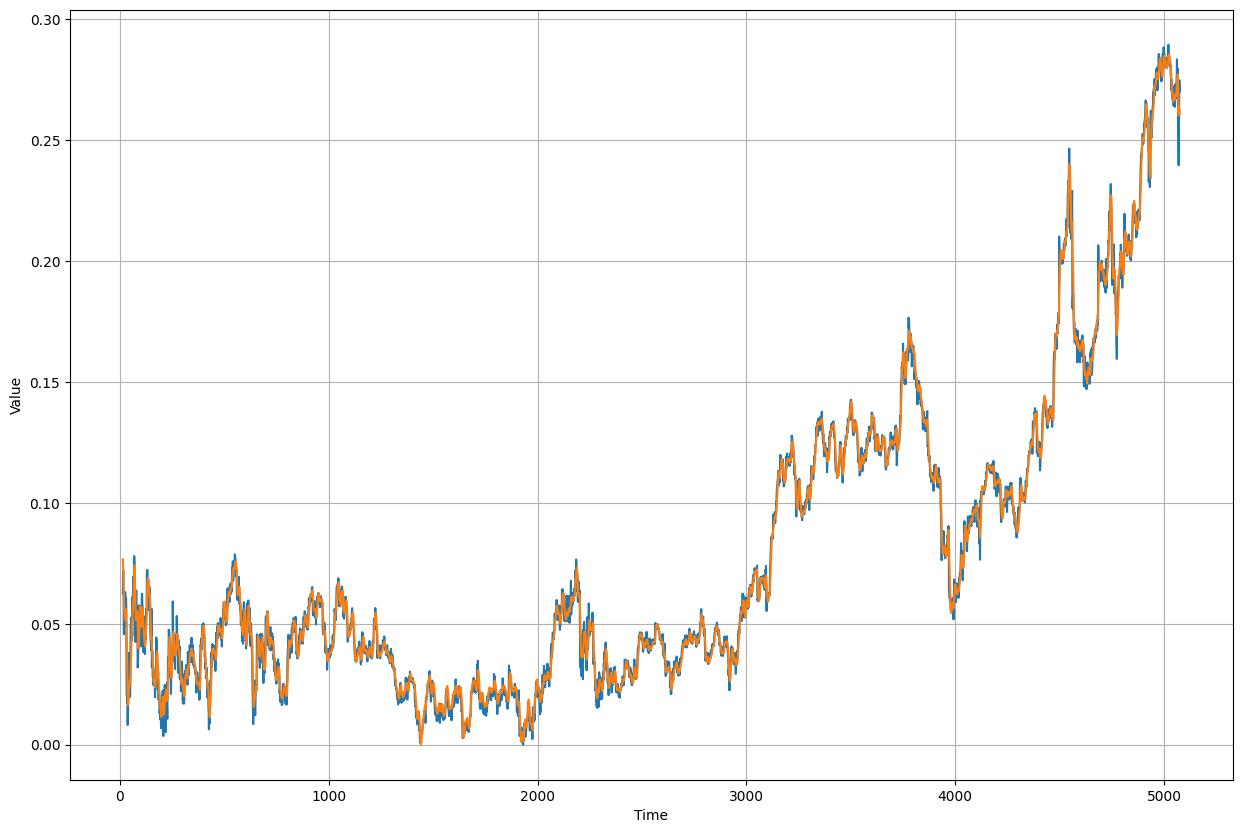

In [10]:
# Reduce the original series
forecast_series = close

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()
plot_series(time_step[window_size-1:],(close[window_size-1:],results), xlabel='Time', ylabel='Value')

mse_all=tf.keras.metrics.mse(close[window_size-1:], results).numpy()

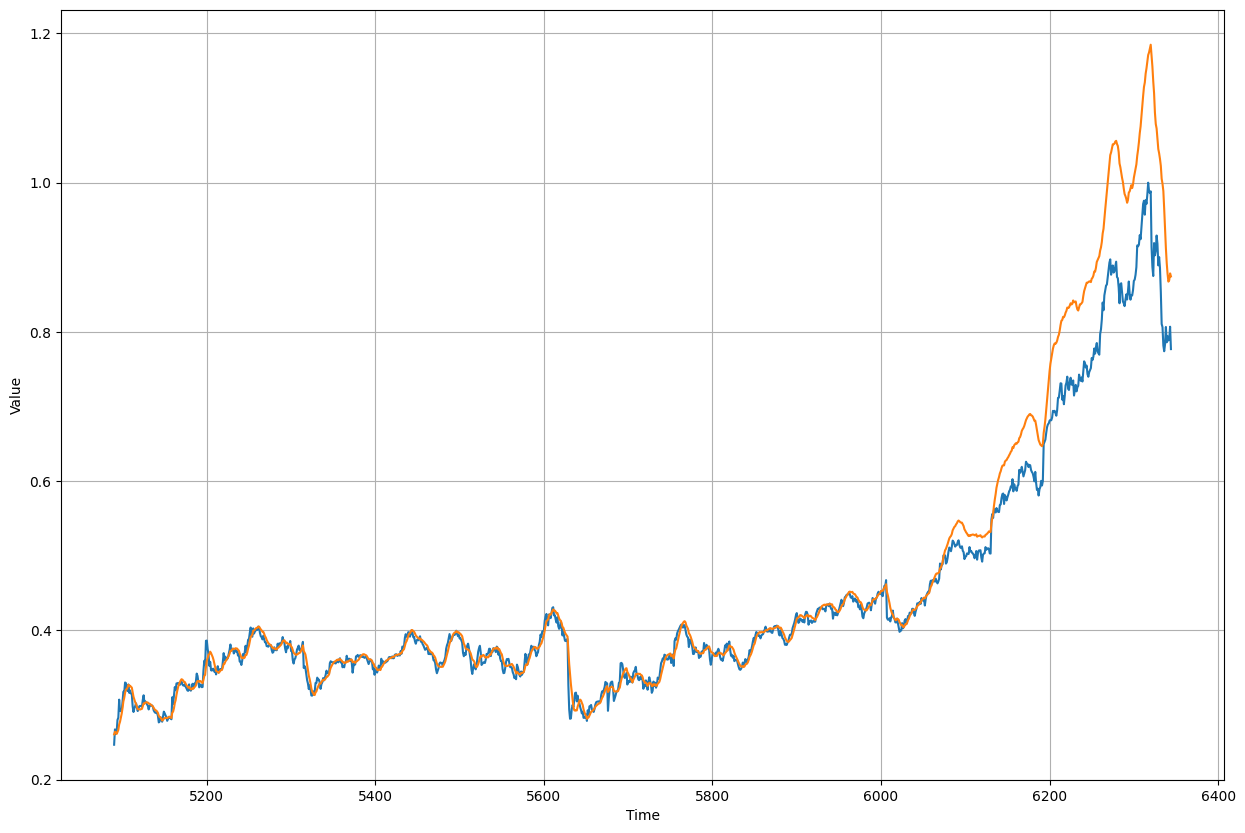

In [11]:

forecast_series = valid_y
forecast = model_forecast(model, forecast_series, window_size, batch_size)
results = forecast.squeeze()
plot_series(valid_x[window_size-1:],(valid_y[window_size-1:],results), xlabel='Time', ylabel='Value')

mse_test=tf.keras.metrics.mse(valid_y[window_size-1:], results).numpy()

In [12]:
print(f'MSE for all the dataset: {mse_all}')
print(f'MSE for the validation dataset: {mse_test}')

MSE for all the dataset: 1.4735334843862802e-05
MSE for the validation dataset: 0.0023732311092317104
